Импортируем необходимые библиотеки

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from google.colab import files

Загрузка Microsoft dataset (цветные изображения кошек и собак) с 25 тыс. картинок. 
Разбиение dataset на выборки.

In [7]:
train, met = tfds.load('cats_vs_dogs', split=['train[:100%]'], with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4CLB6L/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Функция преобразования картинок для работы в НС. 

In [8]:
SIZE = 224
def resize_image(img, label):
  img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, (SIZE, SIZE))
  img = img / 255.0
  return img, label

Применение функции resize_image на наши данные для обучения. И разбиение выборки на части 

In [9]:
train_resized = train[0].map(resize_image)
train_batches = train_resized.shuffle(1000).batch(16)

Создание НС. У нас будет свёрточная НС. Загружаем некоторые обученые слои СНС (из keras).

In [10]:
base_layers = tf.keras.applications.MobileNetV2(input_shape=(SIZE, SIZE, 3), include_top=False)
base_layers.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


Собираем нашу модель из keras слоев и финальных, которые и будет отвечать за вывод. Dropout(0.2), чтобы избежать заучивания. В качестве оптимизатора будем использовать не обычный стохастический градиентный
спуск, а его модификацию ADAM – Adaptive Moment Estimation. 

In [11]:
model = tf.keras.Sequential([
                             base_layers,
                             GlobalAveragePooling2D(),
                             Dropout(0.2),
                             Dense(1)
])
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

Обучаем нашу НС в 2 эпохи, чтобы повысить точность

In [12]:
model.fit(train_batches, epochs=1)

1454/1454 [==============================] - 77s 53ms/step - loss: 0.0672 - accuracy: 0.9740


In [13]:
model.fit(train_batches, epochs=2)

Epoch 1/2
1454/1454 [==============================] - 76s 52ms/step - loss: 0.0452 - accuracy: 0.9834
Epoch 2/2
1454/1454 [==============================] - 75s 52ms/step - loss: 0.0414 - accuracy: 0.9852


Тестируем нашу сеть. Тестируем на 6 картинках. 
Если захотите протекстить на своей картинке (одна картинка), то надо ее делать  в jpg и называть по номеру, ну и надо будет немного поменять код (в ранге).

In [25]:
files.upload()

Saving 1.jpg to 1 (2).jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg


{'1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe1\x00lExif\x00\x00II*\x00\x08\x00\x00\x00\x03\x001\x01\x02\x00\x07\x00\x00\x002\x00\x00\x00\x12\x02\x03\x00\x02\x00\x00\x00\x02\x00\x02\x00i\x87\x04\x00\x01\x00\x00\x00:\x00\x00\x00\x00\x00\x00\x00Picasa\x00\x00\x03\x00\x00\x90\x07\x00\x04\x00\x00\x000220\x02\xa0\x04\x00\x01\x00\x00\x00l\x01\x00\x00\x03\xa0\x04\x00\x01\x00\x00\x00\xcd\x00\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x06\x04\x04\x05\x04\x04\x06\x05\x05\x05\x06\x06\x06\x07\t\x0e\t\t\x08\x08\t\x12\r\r\n\x0e\x15\x12\x16\x16\x15\x12\x14\x14\x17\x1a!\x1c\x17\x18\x1f\x19\x14\x14\x1d\'\x1d\x1f"#%%%\x16\x1c),($+!$%$\xff\xdb\x00C\x01\x06\x06\x06\t\x08\t\x11\t\t\x11$\x18\x14\x18$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\xff\xc0\x00\x11\x08\x00\xcd\x01l\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x0

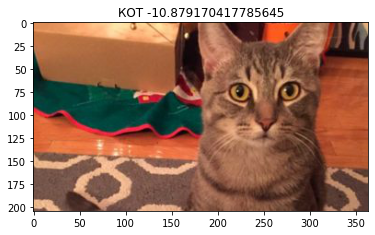

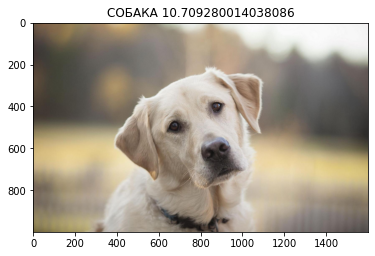

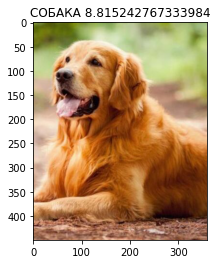

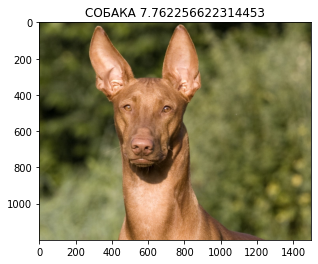

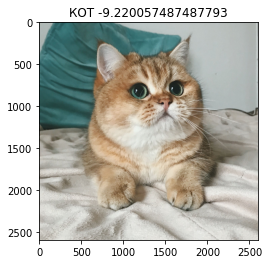

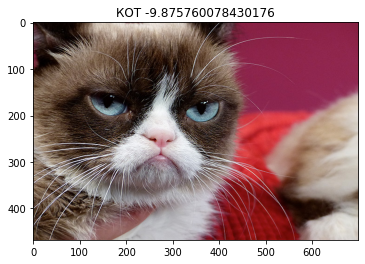

In [26]:
for i in range(6):
  img = load_img(f'{i+1}.jpg')
  img_array = img_to_array(img)
  img_resized, _ = resize_image(img_array, _)
  img_expended = np.expand_dims(img_resized, axis=0)
  prediction = model.predict(img_expended)[0][0]
  pred_label = 'КОТ' if prediction < 0.5 else 'СОБАКА'
  plt.figure()
  plt.imshow(img)
  plt.title(f'{pred_label} {prediction}')